## Loan Sanction Amount Predict 貸款批准金額預測
- 根據客戶貸款資料，預測客戶最終獲得批准的房屋貸款金額

### 預測
- 貸款批准金額(美元) (Loan Sanction Amount (USD))

### 特徵定義
- Cutomer ID: ID
- Name: 客戶名字
- Gener: 客戶性別
- Age: 年紀
- Income: 客戶的收入
- Income Stability: 客戶是否具有穩定的收入來源
- Profession: 客戶的職業
- Type of Employment: 客戶的就業類型
- Location: 客戶的當前居住位置
- Loan Amount Request: 客戶要求的貸款金額
- Current Loan Expenses: 如果客戶有任何當前的有效貸款，那麼這代表了客戶目前在這貸款上花費的金額（每月）
- Expense Type 1: 代表客戶花費的一種或費用（每月）
- Expense Type 2: 代表客戶花費的一種或費用（每月）
- Dependents: 客戶是否有任何親屬（配偶，父母，兄弟姐妹，兒童等）
- Credit Score: 客戶的信用評分
- No. of Defaults: 表示客戶違約的次數
- Has Active Credit Card: 客戶是否有任何有效的信用卡
- Property ID: 房地產ID
- Property Type: 房地產類型
- Property Location: 房地產位置
- Co-Applicant: 客戶是否有共同申請人
- Property Price: 房地產價格
- Loan Sanction Amount (USD) : 最終批准的貸款金額

In [386]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder # 用於特徵提取, 將數值資料轉為離散

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
from keras.utils import np_utils
from tensorflow.keras.layers import Dense      # Dense 建立網路
from tensorflow.keras.models import Sequential # Sequential 初始化神經網路

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format','{:}'.format)
# # 數值顯示至小數點後第二位
# pd.set_option('display.precision',2)

In [387]:
# 載入資料集
dataset = pd.read_csv('./data/Loan Sanction Amount Predict/Loan sanction amount prediction.csv', encoding='utf8')
dataset.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.4,0,Unpossessed,608,4952.91,2,Rural,1,54791.0,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.7,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


#### 觀察資料
> 移除明顯無法作為特徵的欄位
> Customer ID、Name、Property ID

In [388]:
# 移除 ID 欄位
dataset.drop("Customer ID", axis=1, inplace=True)
dataset.drop("Name", axis=1, inplace=True)
dataset.drop("Property ID", axis=1, inplace=True)

# 確認資料特徵類型
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       29947 non-null  object 
 1   Age                          30000 non-null  int64  
 2   Income (USD)                 25424 non-null  float64
 3   Income Stability             28317 non-null  object 
 4   Profession                   30000 non-null  object 
 5   Type of Employment           22730 non-null  object 
 6   Location                     30000 non-null  object 
 7   Loan Amount Request (USD)    30000 non-null  float64
 8   Current Loan Expenses (USD)  29828 non-null  float64
 9   Expense Type 1               30000 non-null  object 
 10  Expense Type 2               30000 non-null  object 
 11  Dependents                   27507 non-null  float64
 12  Credit Score                 28297 non-null  float64
 13  No. of Defaults 

In [389]:
dataset.describe().round(1)

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,30000.0,25424.0,30000.0,29828.0,27507.0,28297.0,30000.0,25150.0,30000.0,30000.0,30000.0,29660.0
mean,40.1,2630.6,88826.3,400.9,2.3,739.9,0.2,2631.1,2.5,-4.7,131759.7,47649.3
std,16.0,11262.7,59536.9,242.5,1.0,72.2,0.4,11322.7,1.1,74.6,93549.5,48221.1
min,18.0,377.7,6048.2,-999.0,1.0,580.0,0.0,377.7,1.0,-999.0,-999.0,-999.0
25%,25.0,1650.5,41177.8,247.7,2.0,681.9,0.0,1650.4,1.0,1.0,60572.2,0.0
50%,40.0,2222.4,75128.1,375.2,2.0,739.8,0.0,2223.2,2.0,1.0,109993.6,35209.4
75%,55.0,3090.6,119964.6,521.3,3.0,799.1,0.0,3091.4,3.0,1.0,178880.7,74261.2
max,65.0,1777460.2,621497.8,3840.9,14.0,896.3,1.0,1777460.2,4.0,1.0,1077966.7,481907.3


#### 檢查缺失值 Missing Value

Text(0.5, 1.0, '資料集中的缺失值數量')

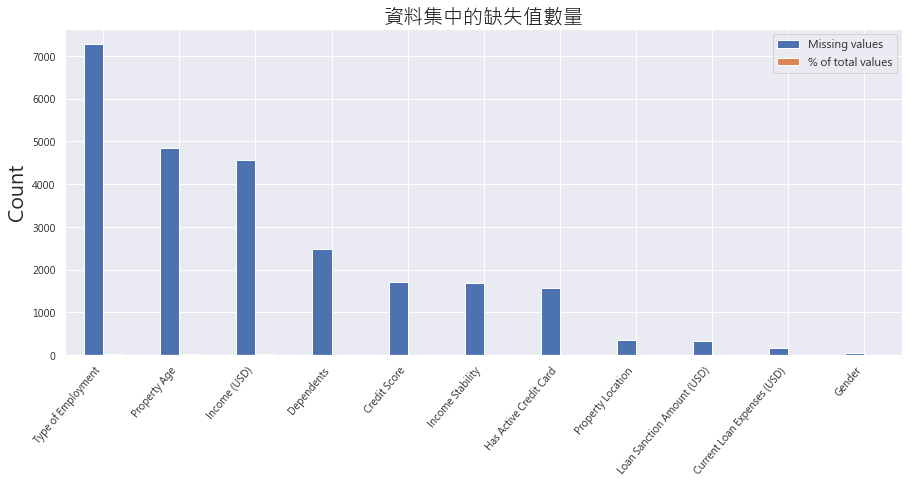

In [390]:
# 定義缺失值檢測函數
def missing_value_table(df):
    
    # 計算所有的缺失值
    mis_val = df.isnull().sum()
    
    # 佔 % 比
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 合併
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # 給予合併的表格 每個column各一個新名字
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing values', 1:'% of total values'})
    
    # 剔除沒有缺失值的 並 排序
    # 判斷所有數據中的第一 row .iloc[:,1]!=0] 不等於 0的 
    # .iloc[:,1] 代表Missing value 那個 column
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('Missing values',ascending=False)
    
    return mis_val_rename

missing_value_table(dataset).plot(kind="bar", figsize = (15,6), fontsize = 10)
plt.xticks(rotation=50, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("資料集中的缺失值數量", fontsize = 20)

#### 填補缺失值 Missing Value
> - Loan Sanction Amount (USD) : 對於目標變量為空的row直接拿掉，我不希望有填補出來的值影響判斷
> - Type of Employment : 客戶的就業類型 考慮資料可能存在某種關聯性，我用前一個值來補
> - Property Age : 發現屋齡是用天算的，先將特徵用平均值填補，再轉為年 
> - Income (USD) : 收入用中位數去補，用平均值的話可能會被有錢人拉走
> - Dependents : 親屬人數資料中沒有0，因此判斷缺失值均為0
> - Credit Score : 使用平均值填補
> - Income Stability : 眾數填補
> - Has Active Credit Card : 眾數填補
> - Property Location : 眾數填補
> - Current Loan Expenses (USD) : 發現有負值，用中位數填補
> - Gender : 眾數填補

In [391]:
# 目標值有缺失值的row移除
dataset = dataset.dropna(axis=0, subset = ["Loan Sanction Amount (USD)"])

# 工作類型使用前一個值來補
dataset['Type of Employment'] = dataset['Type of Employment'].fillna(method='pad')

# 屋齡 使用平均數 mean 來填補，再轉成年數
dataset['Property Age'] = dataset['Property Age'].fillna(dataset['Property Age'].mean())
dataset['Property Age'] = dataset['Property Age']/365

# 收入用中位數去補，用平均值的話可能會被有錢人拉走
dataset['Income (USD)'] = dataset['Income (USD)'].fillna(dataset['Income (USD)'].median())

# 親屬人數
dataset['Dependents'] = dataset['Dependents'].fillna(0)

# 信用分數
dataset['Credit Score'] = dataset['Credit Score'].fillna(dataset['Credit Score'].mean())

# 收入穩定度 使用眾數
dataset['Income Stability'] = dataset['Income Stability'].fillna(dataset['Income Stability'].mode()[0])

# 是否有信用卡 使用眾數
dataset['Has Active Credit Card'] = dataset['Has Active Credit Card'].fillna(dataset['Has Active Credit Card'].mode()[0])

# 房屋位置 使用眾數
dataset['Property Location'] = dataset['Property Location'].fillna(dataset['Property Location'].mode()[0])

# 當前貸款花費
dataset['Current Loan Expenses (USD)'] = dataset['Current Loan Expenses (USD)'].fillna(dataset['Current Loan Expenses (USD)'].median())

# 性別 使用眾數
dataset['Gender'] = dataset['Gender'].fillna(dataset['Gender'].mode()[0])

#### 異常值檢查與處理 outlier
> - 先用 displot 與 boxplot 觀察資料分布
> - Loan Sanction Amount (USD) :貸款批准金額有負值，影響判斷直接刪除
> - Income (USD) : 有兩個薪資異常，屋齡除365後還是異常，直接刪除他
> - Current Loan Expenses (USD) : 當前的其他貸款費用出現負值，可能沒有貸款，因此補0
> - Co-Applicant：共同申請人有負值，補0
> - 屋齡有超過一百多年的，很正常
> - 房價負的使用中位數補值
> - 最終批准貸款價格過高的資料，察看她信用評分確實很高，申請的貸款金額也很高，因此判斷合理

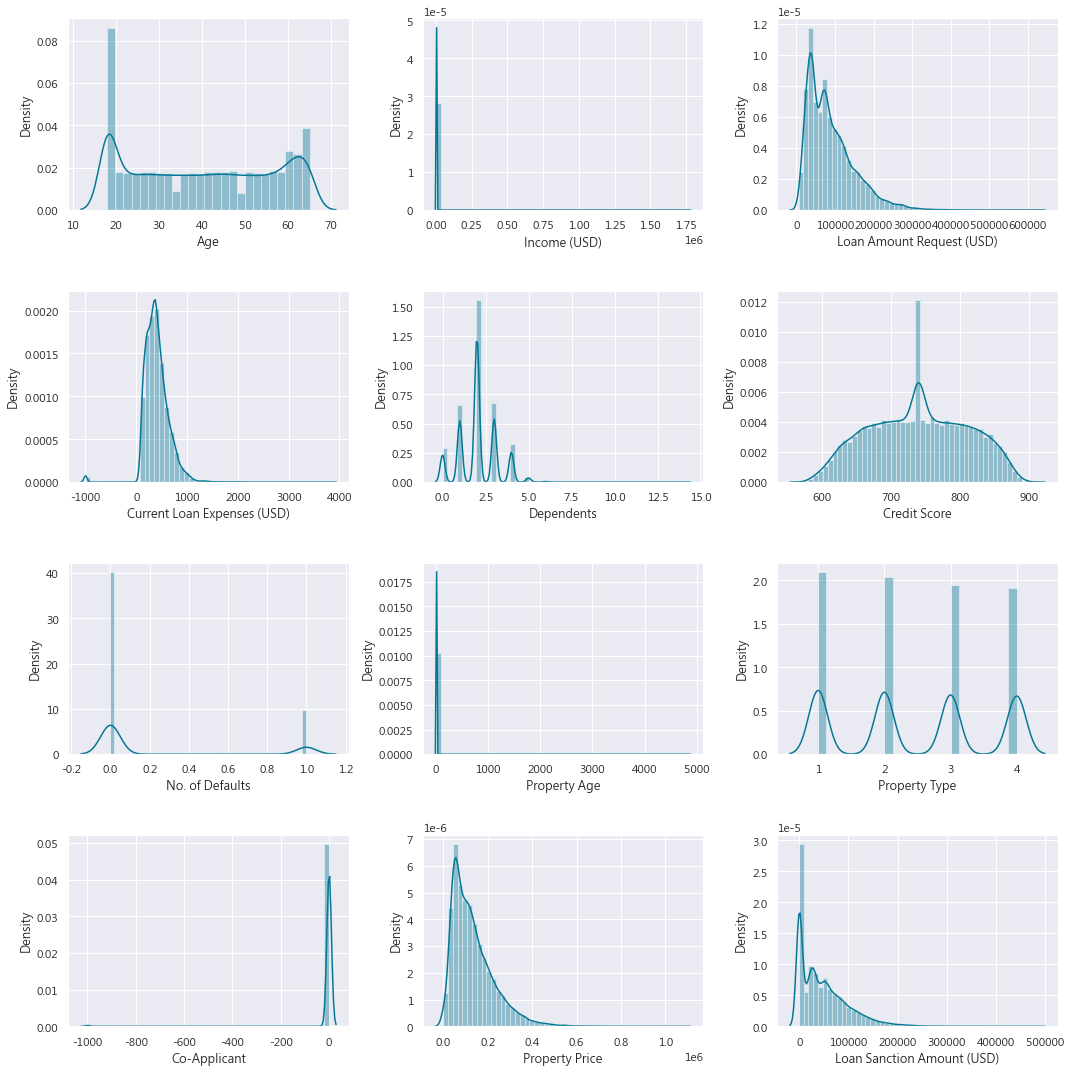

In [392]:
# feature_numerical 取得數值型特徵
feature_numerical = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

# 觀察所有人的核密度直方圖 查看分布
f, ax = plt.subplots(4, 3, figsize=(15, 15))

i, j  = 0, 0
while i < 4:
    for feature in feature_numerical:
        sns.distplot(dataset[feature], ax = ax[i, j], color = '#047794')
        j = j + 1
        if j > 2:
            i = i + 1
            j = 0
            
plt.tight_layout(h_pad=3)            

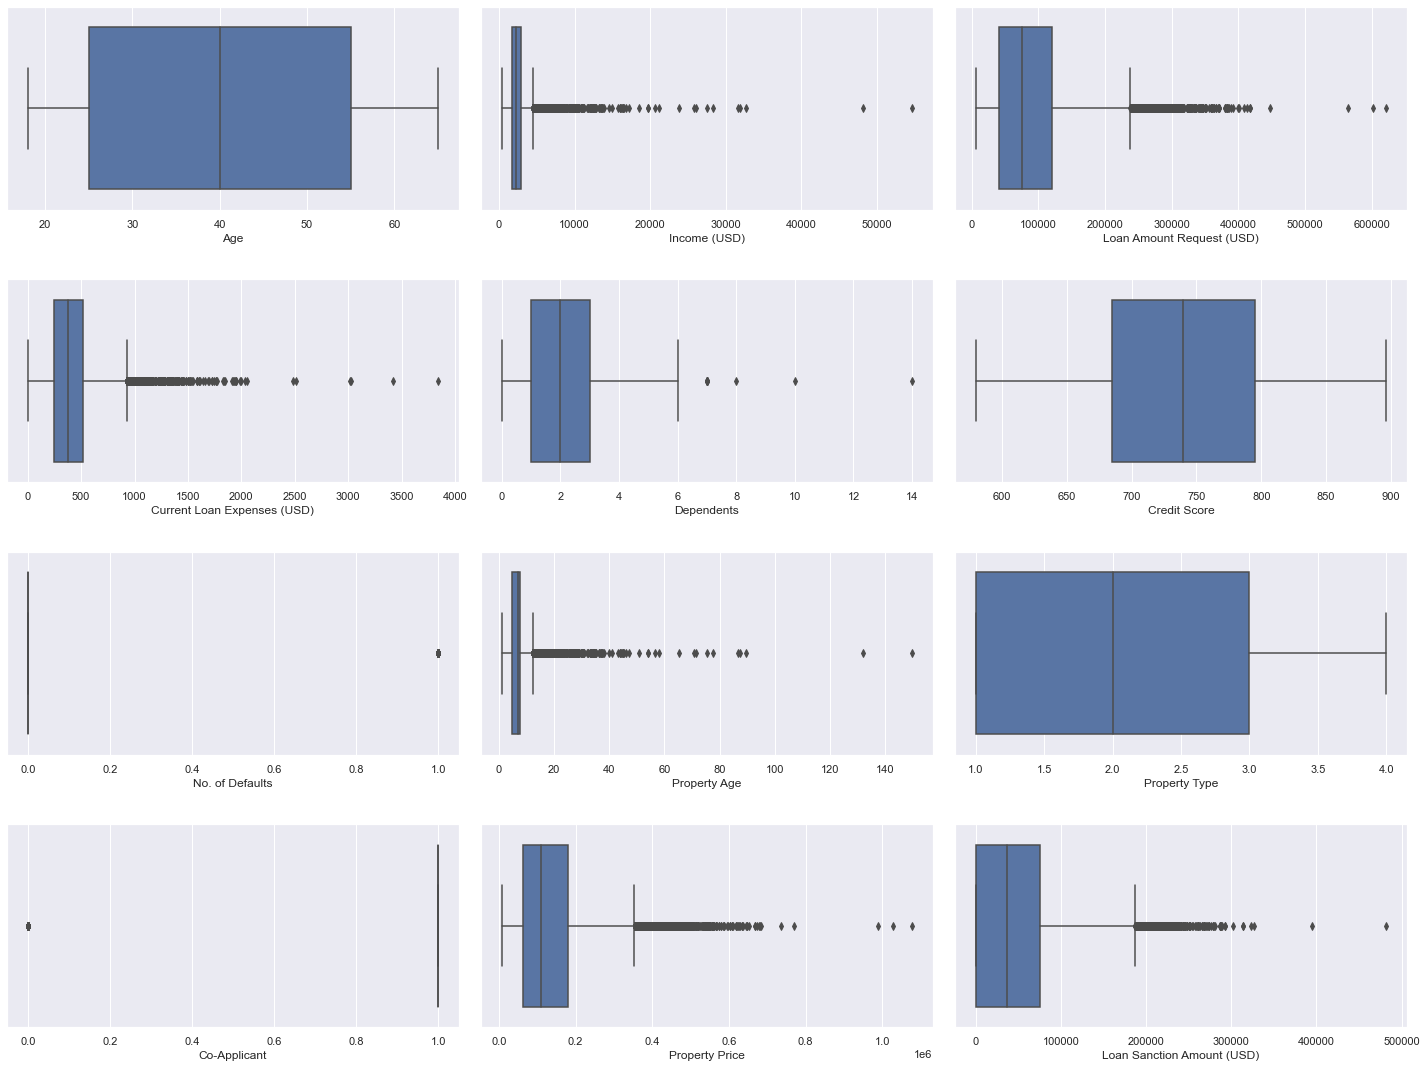

In [408]:
# Boxplot
fig, axes = plt.subplots(4,3)
sns.set(rc={'figure.figsize':(20, 15)})
i, j  = 0, 0
while i < 4:
    for feature in feature_numerical:
        sns.boxplot(x = feature, data = dataset, ax = axes[i, j], palette='deep')
        j = j + 1
        if j > 2:
            i = i + 1
            j = 0
plt.tight_layout(h_pad=3)

In [394]:
# 貸款批准金額　負值row刪除
dataset= dataset.drop(dataset[dataset['Loan Sanction Amount (USD)'] < 0].index)

# 有一個薪資異常，屋齡除365後還是異常，直接刪除他
dataset= dataset.drop(dataset[dataset['Income (USD)'] > 122966].index)

# 當前的其他貸款費用，使用中位數去補
dataset.loc[dataset['Current Loan Expenses (USD)'] < 0 ,'Current Loan Expenses (USD)'] = 0

# 共同申請人負的補0
dataset.loc[dataset['Co-Applicant'] < 0 ,'Co-Applicant'] = 0

# 房屋價格 負的使用中位數補值
dataset.loc[dataset['Property Price'] < 0 ,'Property Price'] = dataset['Property Price'].median()

In [395]:
dataset.describe().round(1).style.background_gradient()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,29320.000000,29320.000000,29320.000000,29320.000000,29320.000000,29320.000000,29320.000000,29320.000000,29320.000000,29320.000000,29320.000000,29320.000000
mean,40.100000,2505.800000,88775.200000,406.500000,2.100000,739.900000,0.200000,7.000000,2.500000,0.800000,132969.500000,48206.000000
std,16.100000,1426.100000,59466.600000,218.400000,1.100000,70.100000,0.400000,3.900000,1.100000,0.400000,92294.100000,48210.300000
min,18.000000,377.700000,6048.200000,0.000000,0.000000,580.000000,0.000000,1.000000,1.000000,0.000000,7266.000000,0.000000
25%,25.000000,1741.600000,41181.800000,248.600000,1.000000,685.300000,0.000000,4.800000,1.000000,1.000000,62380.400000,0.000000
50%,40.000000,2223.300000,75091.300000,375.100000,2.000000,739.900000,0.000000,6.800000,2.000000,1.000000,109995.100000,36059.500000
75%,55.000000,2869.800000,119893.800000,520.000000,3.000000,795.100000,0.000000,7.800000,3.000000,1.000000,178864.100000,74777.400000
max,65.000000,54653.800000,621497.800000,3840.900000,14.000000,896.300000,1.000000,149.700000,4.000000,1.000000,1077966.700000,481907.300000


### EDA (Exploratory Data Analysis) 探索式資料分析 (數值特徵)
> - 數值類型特徵與分類類型特徵分開看  
> - 觀察年紀與貸款金額的關係: 沒有明顯差異
> - 收入越低，似乎貸款金額越高
> - 貸款申請金額明顯與批准金額正相關
> - 當前的其他貸款金額越高，批准的貸款金額也越高
> - 家屬人數越多，貸款批准金額越低！這是為甚麼，因為大家會贊助嗎？？
> - 信用分數明顯低於650就很難申請到貸款，分數越高，貸款的金額稍微高一點
> - 違約的次數與貸款批准金額沒有差異，但是批准金額最高的幾個都是０違約的
> - 屋齡越高，貸款批准金額似乎越低
> - 房屋四種類型與貸款批准金額沒有關係
> - 共同申請人越多，批准金額高了一點
> - 房屋價格明顯與貸款批准金額正相關

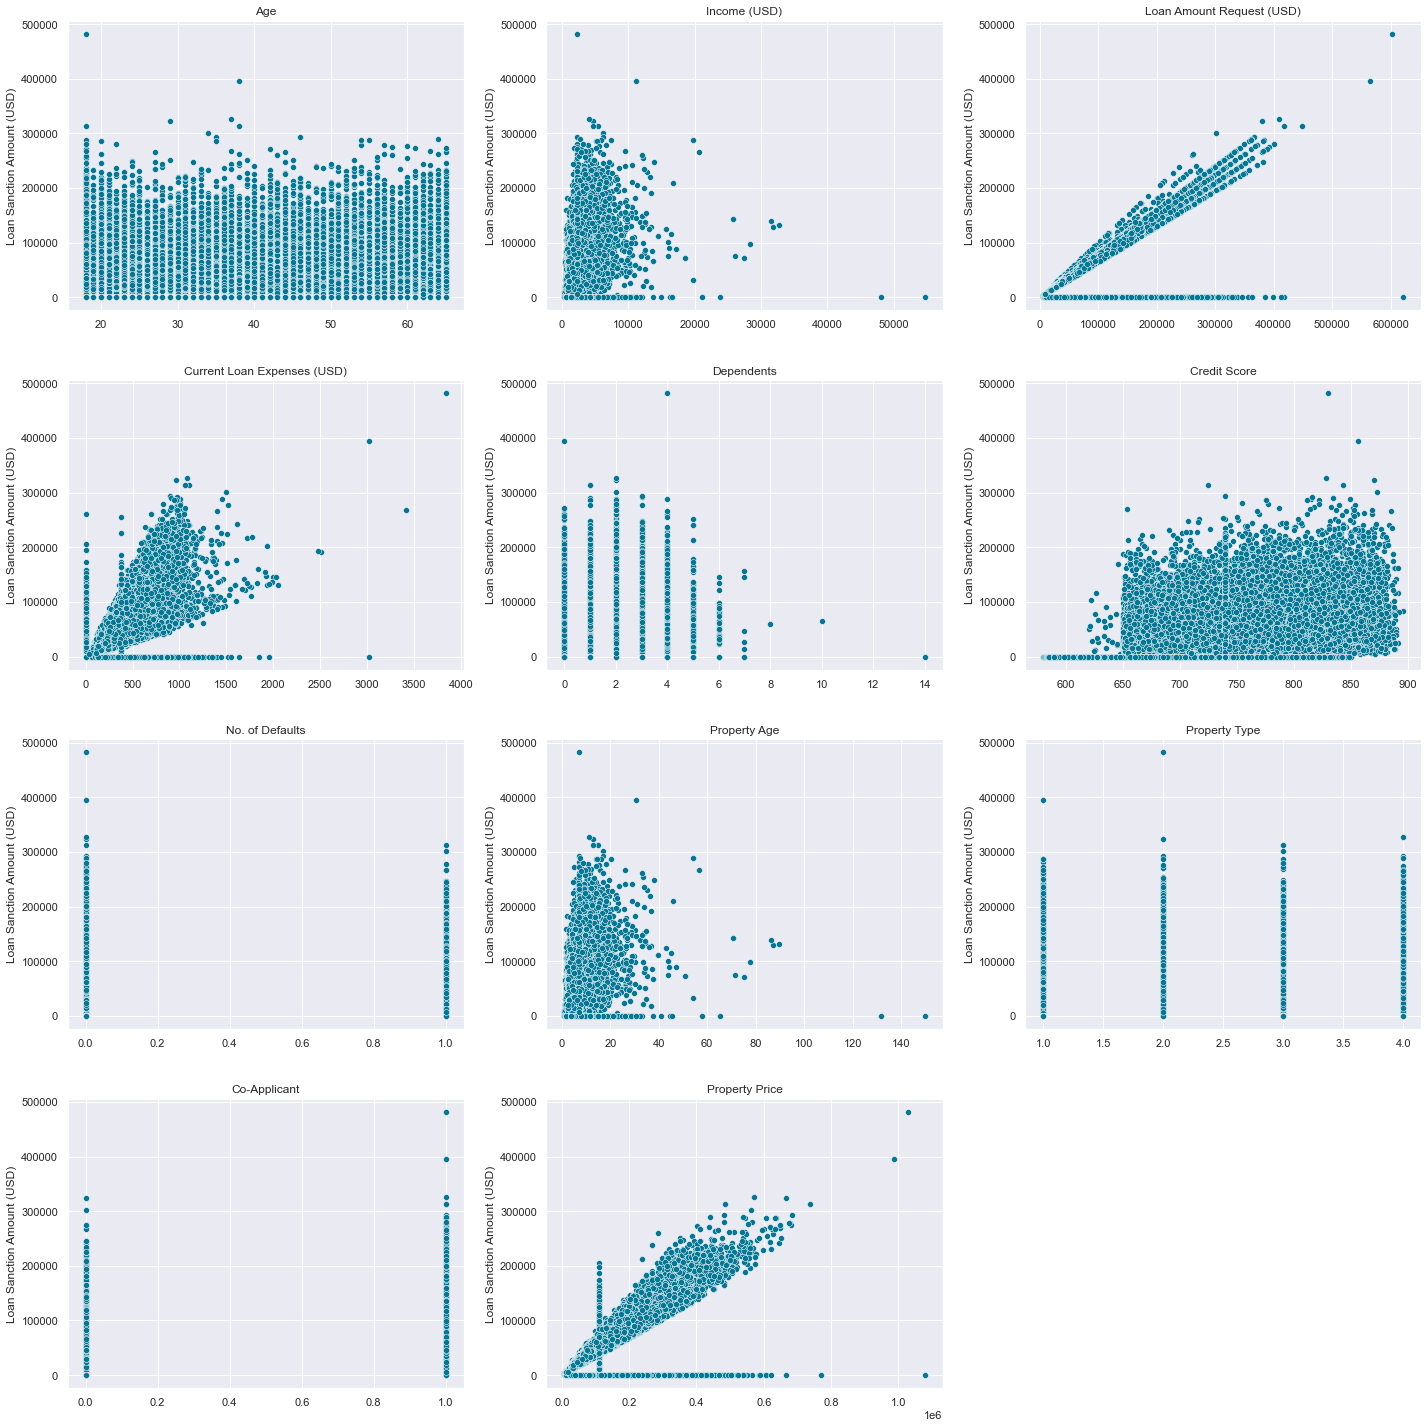

In [396]:
# 觀察數值類型的特徵
plt.figure(figsize=(20,20))
# enumerate 列舉 ==> i :index ; source: 內容
for i, source in enumerate(feature_numerical):
    if source == "Loan Sanction Amount (USD)":
        continue
    # 指定好子圖的位置 
    plt.subplot(4, 3, i+1)
    # scatterplot
    sns.scatterplot( x = source, y="Loan Sanction Amount (USD)", data = dataset, color = '#047794').set(xlabel=None)
    plt.title(source)
    
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

### EDA (Exploratory Data Analysis) 探索式資料分析 (類別特徵)
> - 性別與貸款批准金額無關
> - 收入穩定度高批准的金額高
> - 職業中學生完全無法貸款，Maternity leave 是唯一一個職業，他的貸款金額最高達到76277，次高為商人，最低的是失業者，且誤差非常大
> - 職務類別中，low skill laborer貸款批准金額最低，合理，Manager最高
> - 申請人地點在城市最高，鄉村最低，但是房屋的地點卻沒有太大的相關，在城市的房子略高
> - Expense 系列中，有花錢的　貸款金額都比較高
> - 信用卡活耀度與批准金額沒有太大的關係

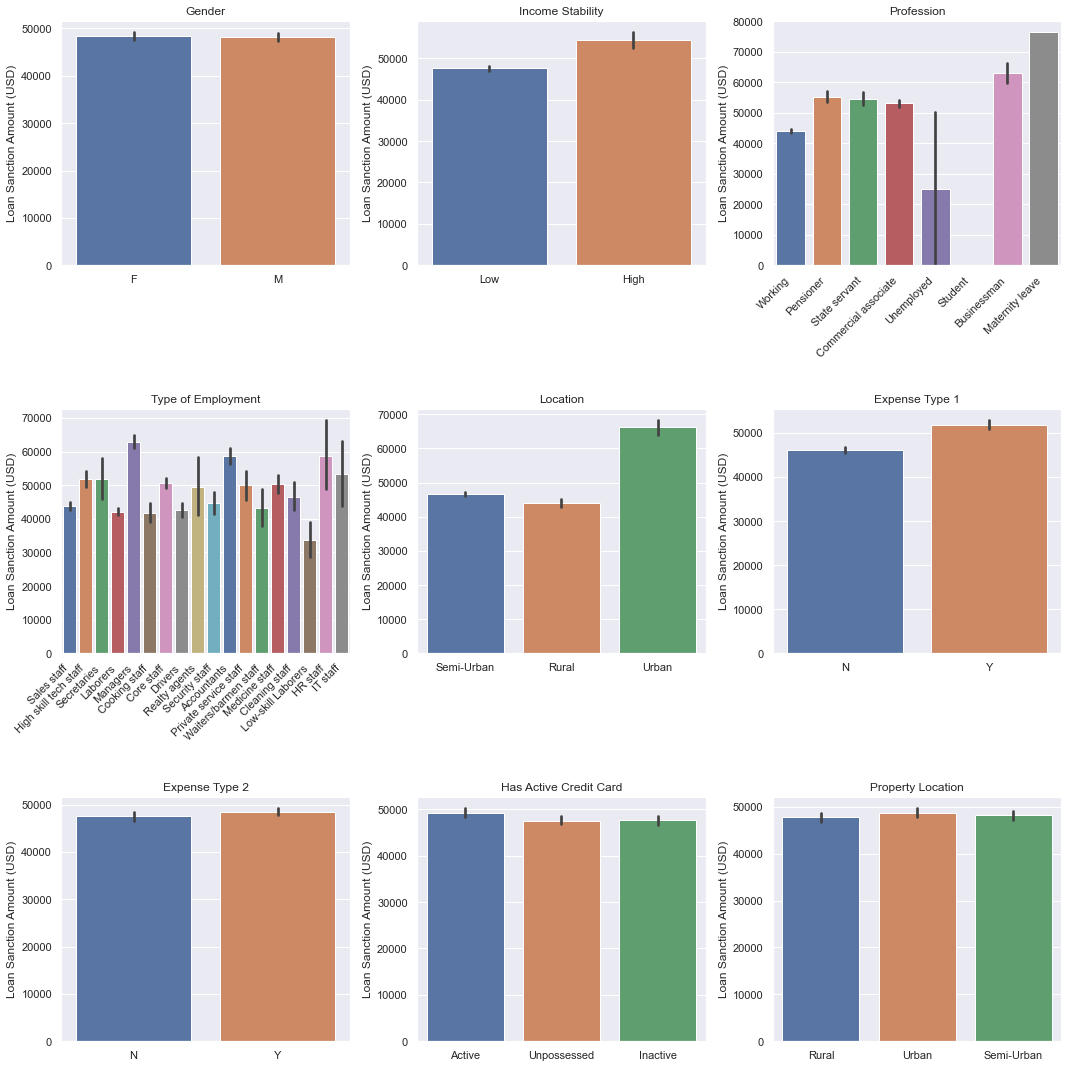

In [397]:
# feature_numerical 取得類別型特徵
feature_object = [feature for feature in dataset.columns if dataset[feature].dtypes == 'object']

# 觀察 Object 類型的特徵
plt.figure(figsize=(15,15))
for i, source in enumerate(feature_object):
    # 指定好子圖的位置 
    plt.subplot(3, 3, i+1)
    sns.barplot(x=source, y="Loan Sanction Amount (USD)", data=dataset, palette = 'deep').set(xlabel=None)
    plt.title(source)
    if source in ["Type of Employment","Profession"]:
        plt.xticks(rotation=45, ha='right')
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

## 特徵工程
>1. 特徵建構: 從原始數據中人工的構建新的特徵，取代原始數據的特徵  
>2. 特徵提取: 將機器學習演算法不能識別的原始數據，轉化為演算法可以識別的特徵
    - 特徵提取的首要任務是將變數從文字轉換成數字，連續數值轉為離散數值，以利統計與導入演算法模型
>3. 特徵選擇: 從所有的特徵中選擇一組最好的特徵集，捨去無關的特徵，保留相關性高的特徵
    - 使用相關性作圖(Pearson相關係數)，顏色較淺的部分為沒有關係的，顏色偏藍就是正相關，顏色偏紅就是負相關。

### 1. 特徵建構

### 2. 特徵提取

In [398]:
# 對分類目標做標籤化處理
dataset['Gender'] = LabelEncoder().fit_transform(dataset['Gender'])
dataset['Income Stability'] = LabelEncoder().fit_transform(dataset['Income Stability'])
dataset['Location'] = LabelEncoder().fit_transform(dataset['Location'])
dataset['Expense Type 1'] = LabelEncoder().fit_transform(dataset['Expense Type 1'])
dataset['Expense Type 2'] = LabelEncoder().fit_transform(dataset['Expense Type 2'])
dataset['Has Active Credit Card'] = LabelEncoder().fit_transform(dataset['Has Active Credit Card'])
dataset['Property Location'] = LabelEncoder().fit_transform(dataset['Property Location'])
# one-hot-Encoding 類別資料
dataset = pd.get_dummies(data = dataset, columns=['Profession'])
dataset = pd.get_dummies(data = dataset, columns=['Type of Employment'])
dataset.head()

,Gender,Age,Income (USD),Income Stability,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),Profession_Businessman,Profession_Commercial associate,Profession_Maternity leave,Profession_Pensioner,Profession_State servant,Profession_Student,Profession_Unemployed,Profession_Working,Type of Employment_Accountants,Type of Employment_Cleaning staff,Type of Employment_Cooking staff,Type of Employment_Core staff,Type of Employment_Drivers,Type of Employment_HR staff,Type of Employment_High skill tech staff,Type of Employment_IT staff,Type of Employment_Laborers,Type of Employment_Low-skill Laborers,Type of Employment_Managers,Type of Employment_Medicine staff,Type of Employment_Private service staff,Type of Employment_Realty agents,Type of Employment_Sales staff,Type of Employment_Secretaries,Type of Employment_Security staff,Type of Employment_Waiters/barmen staff
0,0,56,1933.05,1,1,72809.58,241.08,0,0,3.0,809.44,0,0,5.296027397260274,4,0,1,119933.46,54607.18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,32,4952.91,1,1,46837.47,495.81,0,1,1.0,780.4,0,2,13.569616438356164,2,0,1,54791.0,37469.98,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,65,988.19,0,1,45593.04,171.95,0,1,1.0,833.15,0,2,2.7073698630136986,2,2,0,72440.58,36474.43,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,65,2223.3,0,0,80057.92,298.54,0,1,2.0,832.7,1,2,7.209088451339605,2,1,1,121441.51,56040.54,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,31,2614.77,1,1,113858.89,491.41,0,1,0.0,745.55,1,0,7.163753424657534,4,1,1,208567.91,74008.28,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### 3. 特徵選擇

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

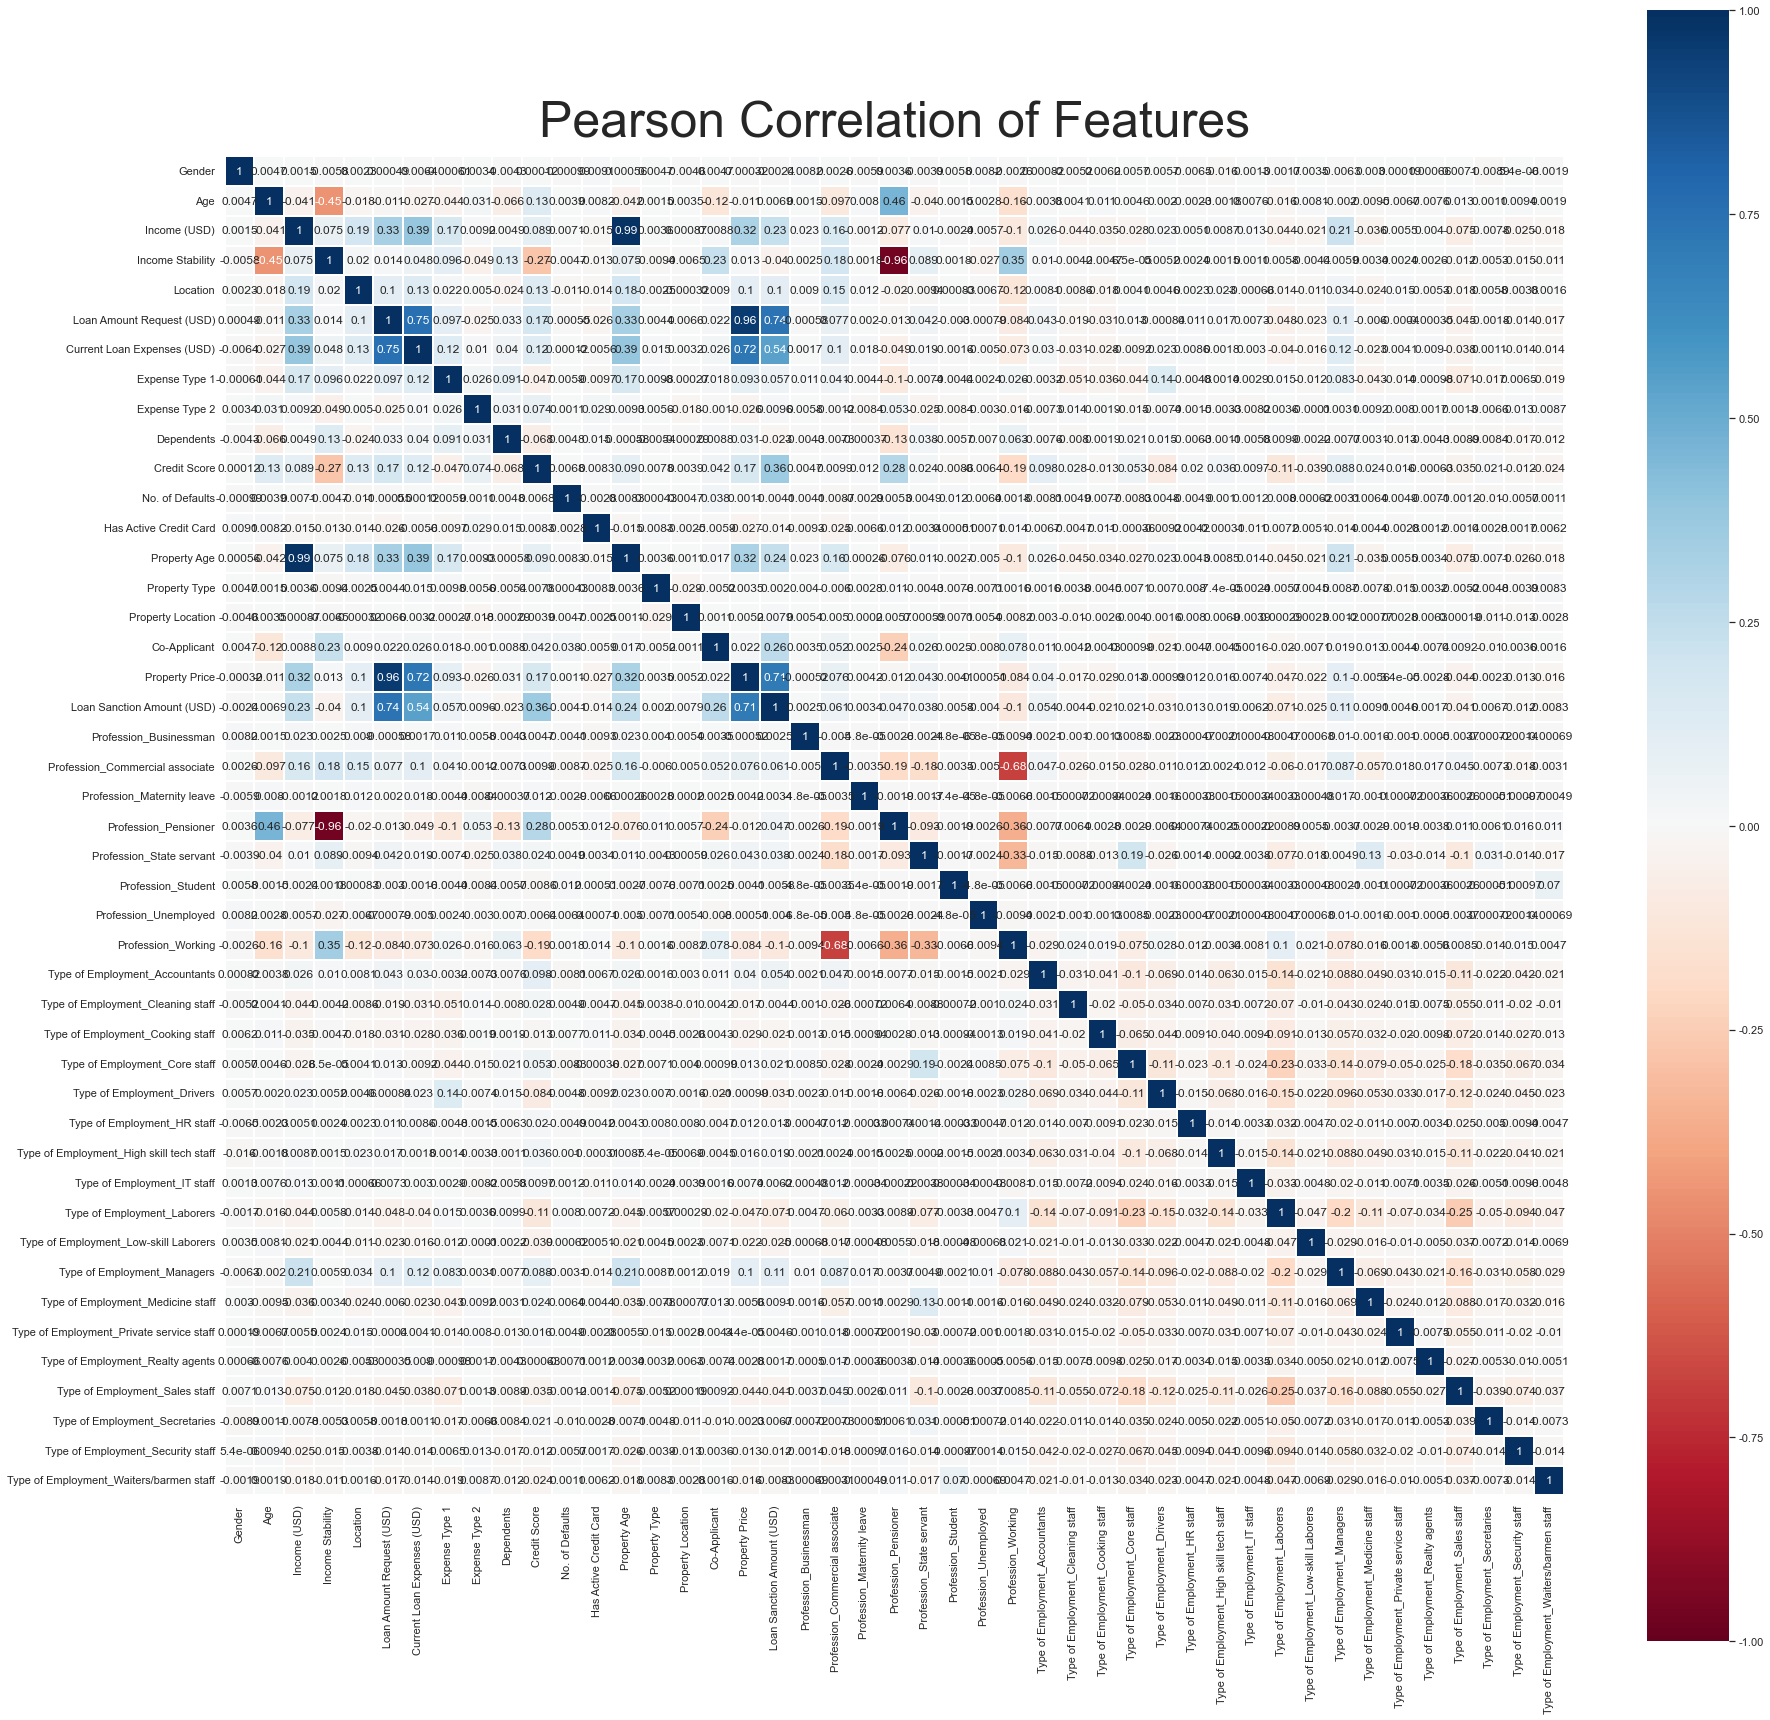

In [399]:
# 先建立空圖
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 30))
plt.title('Pearson Correlation of Features', y = 1.01, size = 50)

# 再將資料加入圖中
sns.heatmap(dataset.astype(float).corr(), linewidths = 0.1, vmin = -1.0 ,vmax = 1.0, square = True, cmap = colormap, 
            linecolor = 'white', annot = True, xticklabels = True, yticklabels = True)

## 準備訓練資料

In [400]:
# 訓練資料處理
y = dataset['Loan Sanction Amount (USD)']
X = dataset.drop(['Loan Sanction Amount (USD)'], axis = 1) # 刪除指定column

print('X shape: '+str(X.shape))
print('y shape: '+str(y.shape))

X shape: (29320, 44)
y shape: (29320,)


In [401]:
# 將資料分割成訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [403]:
# 特徵縮放
minMaxScaler = MinMaxScaler()
robustScaler = RobustScaler()
standardScaler = StandardScaler()

min_max_scaler = ['Age', 'Current Loan Expenses (USD)']
robust_scaler = ['Loan Amount Request (USD)','Income (USD)']
standard_scaler = ['Credit Score']

X_train[min_max_scaler] = minMaxScaler.fit_transform(X_train[min_max_scaler])
X_test[min_max_scaler] = minMaxScaler.transform(X_test[min_max_scaler])
X_train[robust_scaler] = robustScaler.fit_transform(X_train[robust_scaler])
X_test[robust_scaler] = robustScaler.transform(X_test[robust_scaler])
X_train[standard_scaler] = standardScaler.fit_transform(X_train[standard_scaler])
X_test[standard_scaler] = standardScaler.transform(X_test[standard_scaler])

X_train = pd.DataFrame(X_train)
X_train.head()

,Gender,Age,Income (USD),Income Stability,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Profession_Businessman,Profession_Commercial associate,Profession_Maternity leave,Profession_Pensioner,Profession_State servant,Profession_Student,Profession_Unemployed,Profession_Working,Type of Employment_Accountants,Type of Employment_Cleaning staff,Type of Employment_Cooking staff,Type of Employment_Core staff,Type of Employment_Drivers,Type of Employment_HR staff,Type of Employment_High skill tech staff,Type of Employment_IT staff,Type of Employment_Laborers,Type of Employment_Low-skill Laborers,Type of Employment_Managers,Type of Employment_Medicine staff,Type of Employment_Private service staff,Type of Employment_Realty agents,Type of Employment_Sales staff,Type of Employment_Secretaries,Type of Employment_Security staff,Type of Employment_Waiters/barmen staff
20902,1,0.9361702127659576,-1.119345303705836,0,1,-0.2322245633762307,0.09542604819728812,1,0,2.0,0.33635325624108436,0,0,2.683041095890411,3,1,1,96602.95,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
14027,0,1.0,-1.0012822185530272,0,0,0.0033084675619126282,0.05833038262064943,0,0,2.0,0.806017807567947,0,2,3.0425205479452053,2,1,1,135595.17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4686,1,0.8297872340425533,0.0,1,1,-0.003773331020713148,0.11181031430297222,1,1,3.0,0.33849068593462417,0,1,7.209088451339605,4,0,1,102812.33,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3254,1,0.0,0.0,1,1,-0.09387019852304734,0.11783757888817145,1,0,2.0,-0.0031635599572415237,0,1,7.209088451339605,1,1,1,98173.45,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
14800,1,0.893617021276596,0.7722104997952943,1,1,0.3172616543569194,0.10780862718960237,1,1,1.0,0.30799668897347493,1,0,8.442465753424658,3,2,1,167190.89,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 建立模型

### 1. Linear Regression 線性迴歸

In [404]:
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train,y_train)
print('Linear Regression Training score:', model_LinearRegression.score(X_train, y_train))
y_test_predict = model_LinearRegression.predict(X_test)
r2_score(y_test, y_test_predict)

Linear Regression Training score: 0.6572447492369528


0.6657200657787952

### 2. Random Forest Regression

In [405]:
rf = RandomForestRegressor(n_estimators= 48, random_state=1)

rf.fit(X_train, y_train)
print('rf Training score:', rf.score(X_train, y_train))
y_test_predict = rf.predict(X_test)
r2_score(y_test, y_test_predict)


rf Training score: 0.9666919995418464


0.7784094129115475

In [406]:
dt = DecisionTreeRegressor(max_depth= 6, min_samples_leaf= 13)
dt.fit(X_train, y_train)
print('dt Training score:', dt.score(X_train, y_train))
y_test_predict = dt.predict(X_test)
r2_score(y_test, y_test_predict)

dt Training score: 0.784421030043742


0.775962609639234

### 3. LightGBM

In [407]:
from lightgbm import LGBMRegressor
fit_params ={'early_stopping_rounds':10,
            'eval_metric':'rmse',
            'eval_set':[(X_test,y_test)],
            'eval_names':['valid'],
            'verbose':100}
lgb = LGBMRegressor(max_depth=50,learning_rate =0.01,n_estimators=10000)
lgb.fit(X_train, y_train, **fit_params)
y_pred_test = lgb.predict(X_test)
r2_score(y_test, y_pred_test)

[100]	valid's rmse: 27363.9	valid's l2: 7.48786e+08
[200]	valid's rmse: 23048.2	valid's l2: 5.31218e+08
[300]	valid's rmse: 22278.5	valid's l2: 4.96333e+08
[400]	valid's rmse: 22094.4	valid's l2: 4.88161e+08


0.7923472109126286